# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_dataset = datasets.Imagenette(
    root='./data', 
    size='160px',
    download=False, 
)

In [3]:
raw_dataset

Dataset Imagenette
    Number of datapoints: 9469
    Root location: ./data

In [4]:
print(f"Clases del dataset: {raw_dataset.classes}")
print(f"Número de clases: {len(raw_dataset.classes)}")
print(f"Número de imágenes en el conjunto de entrenamiento: {len(raw_dataset)}")

Clases del dataset: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Número de clases: 10
Número de imágenes en el conjunto de entrenamiento: 9469


Image 0 - Label: 0
Image 1 - Label: 0
Image 2 - Label: 0
Image 3 - Label: 0
Image 4 - Label: 0
Image 5 - Label: 0


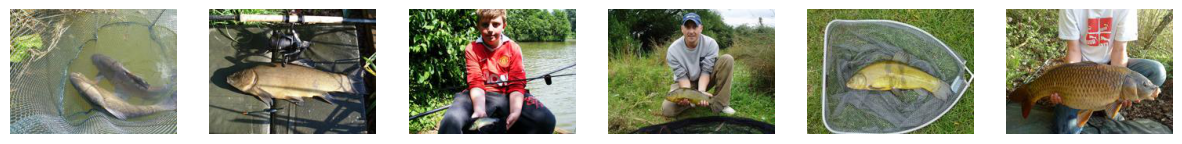

In [5]:
_, ejes = plt.subplots(1, 6, figsize=(15, 5)) 

for i in range(6):
    image, label = raw_dataset[i]
    print(f"Image {i} - Label: {label}")
    plt.imshow(image)

    ax = ejes[i]
    ax.imshow(image)
    ax.axis('off')
    

In [6]:
labels = [label for _, label in raw_dataset]
label_counts = Counter(labels)
label_counts = list(label_counts.items())
df = pd.DataFrame(label_counts, columns=["label_id", "count"])

df


,label_id,count
0,0,963
1,1,955
2,2,993
3,3,858
4,4,941
5,5,956
6,6,961
7,7,931
8,8,951
9,9,960


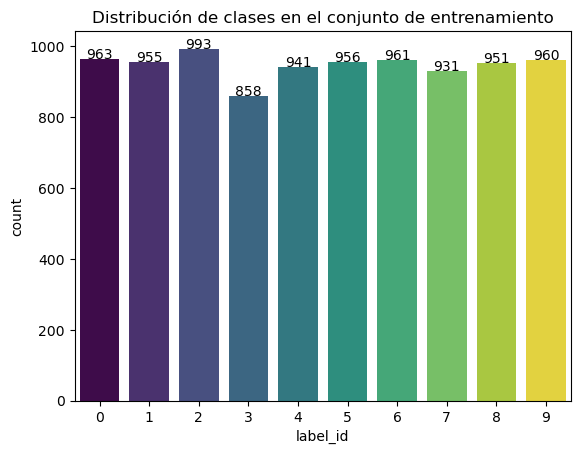

In [7]:
sns.barplot(data=df, x="label_id", y="count", hue="label_id",palette="viridis", legend=False)
plt.title("Distribución de clases en el conjunto de entrenamiento")

for i, row in df.iterrows():
    plt.text(i, row['count'] + 1, str(row['count']), ha='center')

### *Dataset Transformado*

In [8]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root='./data', 
    split='train', 
    size='160px',
    download=False, 
    transform=transform
)

val_dataset = datasets.Imagenette(
    root='./data', 
    split='val', 
    size='160px',
    download=False, 
    transform=transform
)

Image 0 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 1 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 2 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 3 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 4 - Label: 0 - Shape: torch.Size([3, 128, 128])
Image 5 - Label: 0 - Shape: torch.Size([3, 128, 128])


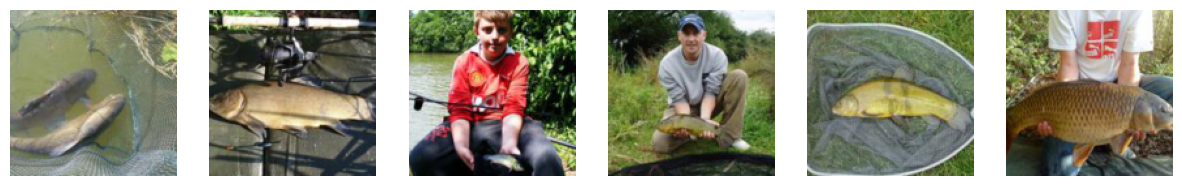

In [9]:
_, ejes = plt.subplots(1, 6, figsize=(15, 5))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for i in range(6):
    image, label = train_data[i]
    print(f"Image {i} - Label: {label} - Shape: {image.shape}")
    image = image.permute(1, 2, 0).numpy() # C,H,W -> H,W,C
    image = std * image + mean # reverse normalization
    image = np.clip(image, 0, 1)
    
    ejes[i].imshow(image)
    ejes[i].axis("off")

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True, num_workers=3
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=3
)

In [11]:
class CNNPrueba(nn.Module):
    def __init__(self, num_classes):
        super(CNNPrueba, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*32*32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Usando dispositivo: {device}")

num_classes = len(train_data.classes)
model = CNNPrueba(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Usando dispositivo: cpu


In [13]:
num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # resetear gradientes
        outputs = model(images)      # forward pass
        loss = criterion(outputs, labels)  # calcular pérdida
        loss.backward()              # backprop
        optimizer.step()             # actualizar pesos

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


  3%|▎         | 1/30 [00:18<09:04, 18.78s/it]

Epoch 1/30, Loss: 1.6873


  7%|▋         | 2/30 [00:45<11:02, 23.66s/it]

Epoch 2/30, Loss: 1.3052


 10%|█         | 3/30 [01:15<11:52, 26.39s/it]

Epoch 3/30, Loss: 1.0878


 13%|█▎        | 4/30 [01:37<10:40, 24.64s/it]

Epoch 4/30, Loss: 0.9297


 17%|█▋        | 5/30 [02:01<10:14, 24.57s/it]

Epoch 5/30, Loss: 0.7922


 20%|██        | 6/30 [02:30<10:20, 25.86s/it]

Epoch 6/30, Loss: 0.6848


 23%|██▎       | 7/30 [02:58<10:11, 26.60s/it]

Epoch 7/30, Loss: 0.5702


 27%|██▋       | 8/30 [03:26<09:56, 27.12s/it]

Epoch 8/30, Loss: 0.4822


 30%|███       | 9/30 [03:51<09:15, 26.44s/it]

Epoch 9/30, Loss: 0.3904


 33%|███▎      | 10/30 [04:05<07:34, 22.73s/it]

Epoch 10/30, Loss: 0.2968


 37%|███▋      | 11/30 [04:20<06:24, 20.22s/it]

Epoch 11/30, Loss: 0.2570


 40%|████      | 12/30 [04:34<05:31, 18.44s/it]

Epoch 12/30, Loss: 0.2029


 43%|████▎     | 13/30 [04:49<04:52, 17.21s/it]

Epoch 13/30, Loss: 0.1627


 47%|████▋     | 14/30 [05:03<04:21, 16.34s/it]

Epoch 14/30, Loss: 0.1259


 50%|█████     | 15/30 [05:18<03:56, 15.78s/it]

Epoch 15/30, Loss: 0.1373


 53%|█████▎    | 16/30 [05:32<03:35, 15.41s/it]

Epoch 16/30, Loss: 0.0999


 57%|█████▋    | 17/30 [05:47<03:16, 15.15s/it]

Epoch 17/30, Loss: 0.0854


 60%|██████    | 18/30 [06:01<02:59, 14.97s/it]

Epoch 18/30, Loss: 0.0778


 63%|██████▎   | 19/30 [06:16<02:43, 14.84s/it]

Epoch 19/30, Loss: 0.0771


 67%|██████▋   | 20/30 [06:30<02:27, 14.79s/it]

Epoch 20/30, Loss: 0.0753


 70%|███████   | 21/30 [06:45<02:12, 14.74s/it]

Epoch 21/30, Loss: 0.0744


 73%|███████▎  | 22/30 [07:00<01:57, 14.68s/it]

Epoch 22/30, Loss: 0.0700


 77%|███████▋  | 23/30 [07:14<01:42, 14.66s/it]

Epoch 23/30, Loss: 0.0707


 80%|████████  | 24/30 [07:29<01:28, 14.67s/it]

Epoch 24/30, Loss: 0.0486


 83%|████████▎ | 25/30 [07:43<01:13, 14.64s/it]

Epoch 25/30, Loss: 0.0405


 87%|████████▋ | 26/30 [07:58<00:58, 14.64s/it]

Epoch 26/30, Loss: 0.0538


 90%|█████████ | 27/30 [08:13<00:43, 14.63s/it]

Epoch 27/30, Loss: 0.0668


 93%|█████████▎| 28/30 [08:27<00:29, 14.61s/it]

Epoch 28/30, Loss: 0.0543


 97%|█████████▋| 29/30 [08:43<00:14, 14.84s/it]

Epoch 29/30, Loss: 0.0436


100%|██████████| 30/30 [08:58<00:00, 17.95s/it]

Epoch 30/30, Loss: 0.0476


In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.5885
Validation F1 Score: 0.5857


In [15]:
class CNN_3L(nn.Module):
    def __init__(self, num_classes):
        super(CNN_3L, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
num_classes = len(train_data.classes)
model_2 = CNN_3L(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=1e-3)

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model_2.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # resetear gradientes
        outputs = model_2(images)      # forward pass
        loss = criterion(outputs, labels)  # calcular pérdida
        loss.backward()              # backprop
        optimizer.step()             # actualizar pesos

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

  3%|▎         | 1/30 [00:54<26:30, 54.84s/it]

Epoch 1/30, Loss: 1.6865


  7%|▋         | 2/30 [01:49<25:33, 54.77s/it]

Epoch 2/30, Loss: 1.1794


 10%|█         | 3/30 [02:46<25:02, 55.66s/it]

Epoch 3/30, Loss: 0.9387


 13%|█▎        | 4/30 [03:43<24:19, 56.13s/it]

Epoch 4/30, Loss: 0.7911


 17%|█▋        | 5/30 [04:40<23:36, 56.67s/it]

Epoch 5/30, Loss: 0.6499


 20%|██        | 6/30 [05:39<22:58, 57.45s/it]

Epoch 6/30, Loss: 0.5295


 23%|██▎       | 7/30 [06:39<22:16, 58.13s/it]

Epoch 7/30, Loss: 0.4065


 27%|██▋       | 8/30 [07:38<21:24, 58.37s/it]

Epoch 8/30, Loss: 0.3086


 30%|███       | 9/30 [08:36<20:25, 58.37s/it]

Epoch 9/30, Loss: 0.2381


 33%|███▎      | 10/30 [09:34<19:26, 58.33s/it]

Epoch 10/30, Loss: 0.1907


 37%|███▋      | 11/30 [10:32<18:27, 58.30s/it]

Epoch 11/30, Loss: 0.1536


 40%|████      | 12/30 [11:31<17:28, 58.25s/it]

Epoch 12/30, Loss: 0.1268


 43%|████▎     | 13/30 [12:29<16:28, 58.17s/it]

Epoch 13/30, Loss: 0.1052


 47%|████▋     | 14/30 [13:27<15:32, 58.31s/it]

Epoch 14/30, Loss: 0.0840


 50%|█████     | 15/30 [14:26<14:38, 58.54s/it]

Epoch 15/30, Loss: 0.0755


 53%|█████▎    | 16/30 [15:25<13:41, 58.66s/it]

Epoch 16/30, Loss: 0.0812


 57%|█████▋    | 17/30 [16:24<12:43, 58.70s/it]

Epoch 17/30, Loss: 0.0763


 60%|██████    | 18/30 [17:23<11:46, 58.84s/it]

Epoch 18/30, Loss: 0.0668


 63%|██████▎   | 19/30 [18:22<10:48, 58.96s/it]

Epoch 19/30, Loss: 0.0628


 67%|██████▋   | 20/30 [19:21<09:49, 58.92s/it]

Epoch 20/30, Loss: 0.0578


 70%|███████   | 21/30 [20:20<08:50, 58.93s/it]

Epoch 21/30, Loss: 0.0806


 73%|███████▎  | 22/30 [21:19<07:51, 58.89s/it]

Epoch 22/30, Loss: 0.0596


 77%|███████▋  | 23/30 [22:18<06:52, 58.97s/it]

Epoch 23/30, Loss: 0.0636


 80%|████████  | 24/30 [23:17<05:53, 58.88s/it]

Epoch 24/30, Loss: 0.0540


 83%|████████▎ | 25/30 [24:16<04:54, 58.90s/it]

Epoch 25/30, Loss: 0.0575


 87%|████████▋ | 26/30 [25:15<03:55, 58.87s/it]

Epoch 26/30, Loss: 0.0458


 90%|█████████ | 27/30 [26:14<02:56, 58.90s/it]

Epoch 27/30, Loss: 0.0354


 93%|█████████▎| 28/30 [27:16<01:59, 59.85s/it]

Epoch 28/30, Loss: 0.0515


 97%|█████████▋| 29/30 [28:16<00:59, 59.96s/it]

Epoch 29/30, Loss: 0.0681


100%|██████████| 30/30 [29:16<00:00, 58.54s/it]

Epoch 30/30, Loss: 0.0535


In [17]:
model_2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.6576
Validation F1 Score: 0.6593


In [20]:
class CNN_4L(nn.Module):
    def __init__(self, num_classes):
        super(CNN_4L, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
num_classes = len(train_data.classes)
model_3 = CNN_4L(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_3.parameters(), lr=1e-3)

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model_3.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        # resetear gradientes
        outputs = model_3(images)      # forward pass
        loss = criterion(outputs, labels)  # calcular pérdida
        loss.backward()              # backprop
        optimizer.step()             # actualizar pesos

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

  3%|▎         | 1/30 [01:57<56:37, 117.16s/it]

Epoch 1/30, Loss: 1.7489


  7%|▋         | 2/30 [03:58<55:43, 119.40s/it]

Epoch 2/30, Loss: 1.1410


 10%|█         | 3/30 [05:05<42:57, 95.46s/it] 

Epoch 3/30, Loss: 0.9214


 13%|█▎        | 4/30 [06:15<37:08, 85.71s/it]

Epoch 4/30, Loss: 0.7695


 17%|█▋        | 5/30 [07:28<33:42, 80.89s/it]

Epoch 5/30, Loss: 0.6682


 20%|██        | 6/30 [08:42<31:27, 78.63s/it]

Epoch 6/30, Loss: 0.5472


 23%|██▎       | 7/30 [09:55<29:26, 76.79s/it]

Epoch 7/30, Loss: 0.4552


 27%|██▋       | 8/30 [11:09<27:52, 76.03s/it]

Epoch 8/30, Loss: 0.3821


 30%|███       | 9/30 [12:24<26:24, 75.47s/it]

Epoch 9/30, Loss: 0.3008


 33%|███▎      | 10/30 [13:39<25:06, 75.31s/it]

Epoch 10/30, Loss: 0.2495


 37%|███▋      | 11/30 [14:55<23:56, 75.62s/it]

Epoch 11/30, Loss: 0.1948


 40%|████      | 12/30 [16:12<22:47, 75.96s/it]

Epoch 12/30, Loss: 0.1841


 43%|████▎     | 13/30 [17:27<21:30, 75.92s/it]

Epoch 13/30, Loss: 0.1419


 47%|████▋     | 14/30 [18:44<20:18, 76.18s/it]

Epoch 14/30, Loss: 0.1395


 50%|█████     | 15/30 [20:00<19:01, 76.09s/it]

Epoch 15/30, Loss: 0.1130


 53%|█████▎    | 16/30 [21:17<17:47, 76.23s/it]

Epoch 16/30, Loss: 0.1110


 57%|█████▋    | 17/30 [22:33<16:32, 76.32s/it]

Epoch 17/30, Loss: 0.1073


 60%|██████    | 18/30 [23:51<15:21, 76.77s/it]

Epoch 18/30, Loss: 0.0950


 63%|██████▎   | 19/30 [25:08<14:05, 76.83s/it]

Epoch 19/30, Loss: 0.0969


 67%|██████▋   | 20/30 [26:25<12:50, 77.04s/it]

Epoch 20/30, Loss: 0.0550


 70%|███████   | 21/30 [27:45<11:39, 77.72s/it]

Epoch 21/30, Loss: 0.0686


 73%|███████▎  | 22/30 [29:04<10:25, 78.22s/it]

Epoch 22/30, Loss: 0.0905


 77%|███████▋  | 23/30 [30:24<09:10, 78.71s/it]

Epoch 23/30, Loss: 0.0700


 80%|████████  | 24/30 [31:44<07:54, 79.13s/it]

Epoch 24/30, Loss: 0.0681


 83%|████████▎ | 25/30 [33:06<06:39, 79.84s/it]

Epoch 25/30, Loss: 0.0726


 87%|████████▋ | 26/30 [34:24<05:17, 79.44s/it]

Epoch 26/30, Loss: 0.0995


 90%|█████████ | 27/30 [35:40<03:55, 78.50s/it]

Epoch 27/30, Loss: 0.0660


 93%|█████████▎| 28/30 [36:54<02:34, 77.12s/it]

Epoch 28/30, Loss: 0.0677


 97%|█████████▋| 29/30 [38:06<01:15, 75.52s/it]

Epoch 29/30, Loss: 0.0371


100%|██████████| 30/30 [39:17<00:00, 78.58s/it]

Epoch 30/30, Loss: 0.0550


In [22]:
model_3.eval()
all_preds_3 = []
all_labels_3 = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds_3.extend(predicted.cpu().numpy())
        all_labels_3.extend(labels.cpu().numpy())

acc_3 = accuracy_score(all_labels_3, all_preds_3)
f1_3 = f1_score(all_labels_3, all_preds_3, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.6576
Validation F1 Score: 0.6593
